## Build an image classifier with nothing but keywords

This is a fun little notebook that uses the [google-images-download](https://github.com/hardikvasa/google-images-download) python tool and the [fast.ai](https://github.com/fastai/fastai) pytorch library to create image classifiers by just using keywords. In this case we'll add Corn Dogs to the famous [Hot-Dog-Or-No-Hot-Dog Classifier](https://www.youtube.com/watch?v=ACmydtFDTGs). We'll do that by just specifying the classes 'Hot Dog' and 'Corn Dog', automatically download as much pictures as you want per class from google and fine tune the softmax layer of a ResNet34 model trained on ImageNet.

## Prerequesites

### Make sure you have pytorch and the fast.ai library installed and import the following:

In [0]:
from fastai import *
from fastai.vision import *
import PIL

### Install the downloadtool and the dependencies

Here we'll install the tools needed to download pictures from google. You might have to add sudo rights to some commands (I'm inside a container and root). First the Python download tool:

In [2]:
!pip install google_images_download

     |████████████████████████████████| 911kB 5.1MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=bad4079e7ad786bfa43d607bd765617d3953c4f97518fd56f65832f67c7f4784
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [25]:
import sys, os
!git clone https://github.com/kumartr/psdata.git
%cd psdata
!unzip train.zip
sys.path.append(os.getcwd())

Cloning into 'psdata'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
/content/psdata


UsageError: Line magic function `%unzip` not found.


In [0]:
!unzip train.zip

In [0]:
sys.path.append(os.getcwd())

In [40]:
print(os.getcwd())
path = os.getcwd() #'/content/psdata/'
#(path/'train').ls()
os.listdir('/content/psdata/train')

/content/psdata


['S', 'P']

## Get the pics with keywords

import the tool

In [0]:
from google_images_download import google_images_download

Set Path, image size and number of images to be downloaded. To download more than 100 images you have to install the chrome-driver (you'll find instructions at the bottom of the notebook).

In [0]:
PATH = "/fastai/data/FramePresenternSlides/"
nof_pics = 100

In [0]:
PATH = "/content/psdata/train"

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, valid_pct=0.2,ds_tfms=tfms, size=224).normalize(imagenet_stats)

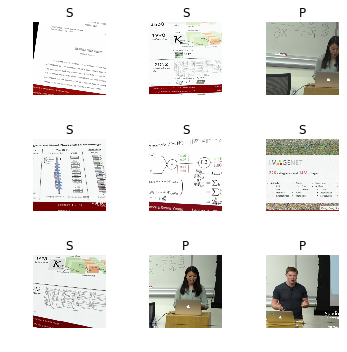

In [48]:
data.show_batch(rows=3, figsize=(5,5))

First we'll instantiate the downloader class. The dictionary `arguments` holds our classes as keywords, the number of files we want per class and the directory where the pics should be saved. If you want to download more than 100 images per class you have to install chrome-driver. When you paste in more keywords more classes will be created Adapt that to your needs!

In [5]:
response = google_images_download.googleimagesdownload()

arguments = {"keywords":"Frame Video Presenter,frame video ppt slides",
             "limit":nof_pics,
             "print_urls":False,
             "output_directory":f'{PATH}train',
             "chromedriver":"/usr/bin/chromedriver"}

paths = response.download(arguments)



Item no.: 1 --> Item name = Frame Video Presenter
Evaluating...
Starting Download...
Completed Image ====> 1.17.png
Completed Image ====> 2.fbi-agent-keith-scott-video1.jpg
Completed Image ====> 3.screen-0.jpg
Completed Image ====> 4.2r2kh0f5lup21.jpg
Completed Image ====> 5.The-Preview-view-shows-the-frame-at-the-cursor-the-dotted-lines-in-Figure-5-and-is.png
Completed Image ====> 6.5c6b2937a4d81.jpg
Completed Image ====> 7.Camtasia-powerpoint-add-in-toolbar.jpg
Completed Image ====> 8.Sample-video-frame-of-size-512-288-left.png
Completed Image ====> 9.Client-Cetnricity-video-frame.png
Completed Image ====> 10.702964387_780x439.jpg
Completed Image ====> 11.hqdefault.jpg
Completed Image ====> 12.hqdefault.jpg
Completed Image ====> 13.2376.hazcomlessonv97tgq.png
Completed Image ====> 14.Attacked-frames-of-Akiyo-a-Frame-dropping-Link-to-download-video-after-attack-b.png
URLError on an image...trying next one... Error: HTTP Error 403: Forbidden
Completed Image ====> 15.video-frame.png
Co

## Clean the data

I sometimes experienced, that corrupted pictures are downloaded. So let's check that and delete them:

In [0]:
def check_images(PATH):
    broken_images=[]
    for pic_class in os.listdir(PATH):
        for pic in os.listdir(f'{PATH}/{pic_class}'):
            try:
                img = PIL.Image.open(f'{PATH}/{pic_class}/{pic}') 
                img.verify()
            except (IOError, SyntaxError) as e:
                print('Bad file:', f'{PATH}/{pic_class}/{pic}')
                broken_images.append(f'{PATH}/{pic_class}/{pic}')
    return broken_images

In [0]:
img_to_del = check_images(f'{PATH}train')

In [0]:
[os.remove(pic) for pic in img_to_del]

[None, None, None, None]

## Extract validation set

Now we need a little function to extract a validation set:

In [0]:
def make_val_set(PATH, nof_val_pics):
    if not os.path.exists(f'{PATH}valid'):
        os.makedirs(f'{PATH}valid')
        for pic_class in os.listdir(f'{PATH}train'):
            os.makedirs(f'{PATH}valid/{pic_class}')
            for pic in random.sample(os.listdir(f'{PATH}train/{pic_class}'), nof_val_pics):
                os.rename(f'{PATH}train/{pic_class}/{pic}', 
                          f'{PATH}valid/{pic_class}/{pic}')
    else:
        warnings.warn("The validation folder already exists! No validation set created.")

Create the validation set. We'll take 20 of the 100 pictures for validation:

In [0]:
make_val_set(PATH, 20)

Initialize data object

In [10]:
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (147 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
frame video ppt slides,frame video ppt slides,frame video ppt slides,frame video ppt slides,frame video ppt slides
Path: /fastai/data/FramePresenternSlides;

Valid: LabelList (38 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
frame video ppt slides,frame video ppt slides,frame video ppt slides,frame video ppt slides,frame video ppt slides
Path: /fastai/data/FramePresenternSlides;

Test: None

## Let's see what a frozen ResNet34 can do

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [51]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.039471,0.163138,0.036364,00:13
1,0.509398,0.021091,0.018182,00:13
2,0.329237,0.000247,0.000000,00:12
3,0.240323,0.000020,0.000000,00:13


In [0]:
learn.save('stage-1')

The interpretation-thing is awesome!!

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

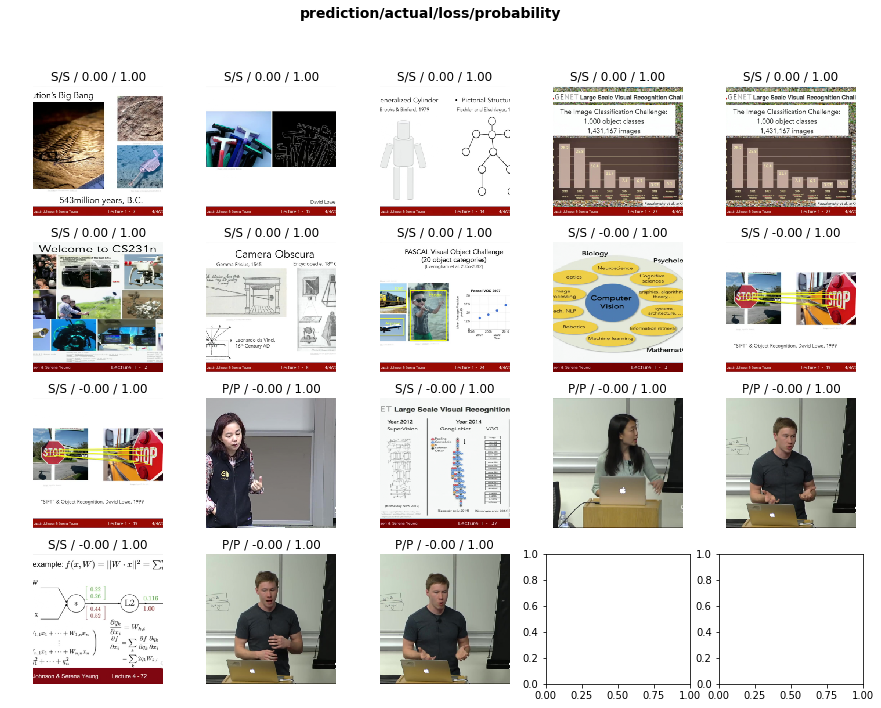

In [55]:
interp.plot_top_losses(18, figsize=(15,11))

There are clearly some non Hot or Corn Dog pictures in the dataset! The confusion matrix looks pretty god:

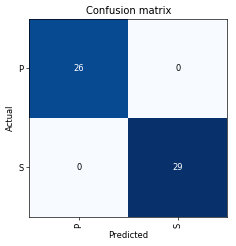

In [56]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

## Let's try to unfreeze:

In [0]:
learn.unfreeze()

find a learning rate

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


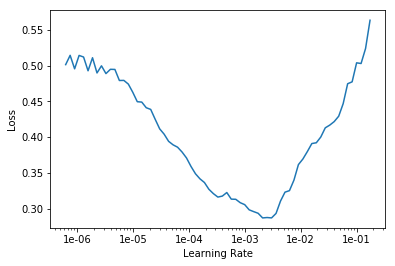

In [23]:
learn.recorder.plot()

10e-4 should be good!

In [24]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.555493,0.312324,0.078947,00:07
1,0.474465,0.219802,0.105263,00:07
2,0.383180,0.171200,0.131579,00:07
3,0.325525,0.177092,0.131579,00:07


Not really an improvement, but in there are only 20 images in the validation set, so that's ok.

## Install chrome-driver if you want to load more than 100 pics

In [0]:
!wget https://chromedriver.storage.googleapis.com/2.35/chromedriver_linux64.zip
!unzip chromedriver_linux64.zip
!mkdir /usr/bin/chromedriver
!mv chromedriver /usr/bin/chromedriver
!chown root:root /usr/bin/chromedriver
!chmod +x /usr/bin/chromedriver
!curl -sS -o - https://dl-ssl.google.com/linux/linux_signing_key.pub | apt-key add
!echo "deb [arch=amd64]  http://dl.google.com/linux/chrome/deb/ stable main" >> /etc/apt/sources.list.d/google-chrome.list
!apt-get -y update
!apt-get -y install google-chrome-stable